# MLP for Classification

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load Data

In [2]:
!cp "/content/drive/MyDrive/colab_projects/MLP for Classification/mobile_price.zip" /content
!unzip "/content/drive/MyDrive/colab_projects/MLP for Classification/mobile_price.zip"

Archive:  /content/drive/MyDrive/colab_projects/MLP for Classification/mobile_price.zip
  inflating: test.csv                
  inflating: train.csv               


In [3]:
df = pd.read_csv('/content/train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
X = df.drop('price_range', axis = 1)

In [5]:
y = df['price_range']

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.7, random_state=42)

## Preprocessing

### Getting info about df

In [7]:
df.shape

(2000, 21)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

### Convert to Tensor

Note that since it's a classification problem, torch expects an integer as output and not a float.

In [9]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

In [10]:
x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

### Standardization

In [11]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

In [12]:
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

## Dataloader

In [13]:
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

In [14]:
valid_data = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=200, shuffle=True)

## Model

In [15]:
num_feats = 20
num_class = 4
h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

## Device

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
model = model.to(device)

## Loss and Optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Torchmetrics

In order to see how well our model has predicted the corresponding classes of each sample, we can use the accuracy metric in torchmetrics

In [20]:
!pip install torchmetrics
from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Model Training

In [21]:
num_epochs = 400

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=4).to(device)
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)

    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item())
    acc_train(outputs, targets)

  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=4).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets)

  loss_train_hist.append(loss_train.avg)
  loss_valid_hist.append(loss_valid.avg)

  acc_train_hist.append(acc_train.compute())
  acc_valid_hist.append(acc_valid.compute())

  if epoch % 10 == 0:
    print(f'Epoch {epoch}')
    print(f'Train: Loss = {loss_train.avg:.4}, Acc = {acc_train.compute():.4}')
    print(f'Valid: Loss = {loss_valid.avg:.4}, Acc = {acc_valid.compute():.4}')
    print()

Epoch 0
Train: Loss = 1.394, Acc = 0.2367
Valid: Loss = 1.394, Acc = 0.2486

Epoch 10
Train: Loss = 1.381, Acc = 0.2517
Valid: Loss = 1.382, Acc = 0.2571

Epoch 20
Train: Loss = 1.369, Acc = 0.2783
Valid: Loss = 1.371, Acc = 0.2779

Epoch 30
Train: Loss = 1.356, Acc = 0.3167
Valid: Loss = 1.358, Acc = 0.3121

Epoch 40
Train: Loss = 1.34, Acc = 0.39
Valid: Loss = 1.342, Acc = 0.3714

Epoch 50
Train: Loss = 1.32, Acc = 0.46
Valid: Loss = 1.322, Acc = 0.4421

Epoch 60
Train: Loss = 1.293, Acc = 0.4883
Valid: Loss = 1.295, Acc = 0.4793

Epoch 70
Train: Loss = 1.258, Acc = 0.5317
Valid: Loss = 1.26, Acc = 0.5121

Epoch 80
Train: Loss = 1.213, Acc = 0.5467
Valid: Loss = 1.215, Acc = 0.5229

Epoch 90
Train: Loss = 1.157, Acc = 0.5583
Valid: Loss = 1.16, Acc = 0.5329

Epoch 100
Train: Loss = 1.093, Acc = 0.5633
Valid: Loss = 1.096, Acc = 0.5486

Epoch 110
Train: Loss = 1.026, Acc = 0.5883
Valid: Loss = 1.029, Acc = 0.5643

Epoch 120
Train: Loss = 0.9583, Acc = 0.61
Valid: Loss = 0.9624, Acc = 

## Evaluation

### Loss

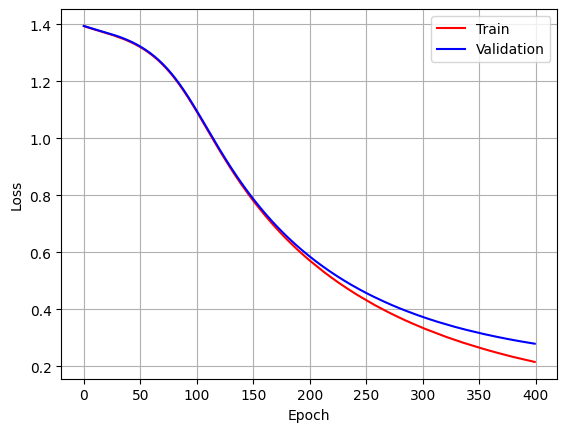

In [22]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

### Accuracy

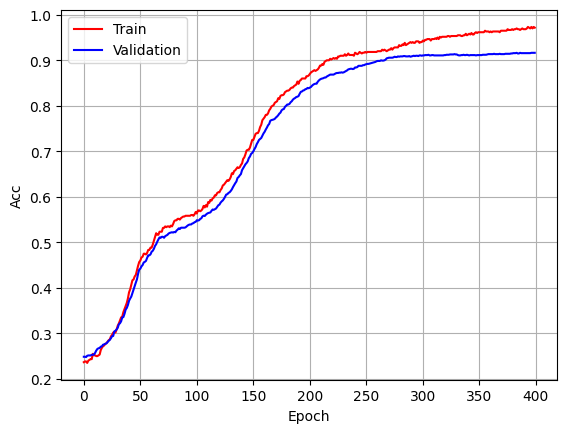

In [23]:
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

## Save Model

In [24]:
torch.save(model, 'model.pth')

In [25]:
mymodel = torch.load('model.pth')